<a href="https://colab.research.google.com/github/fwangliberty/AIoTDesign-Frontend/blob/master/ResNet_50_for_Cats_Vs_Dogs_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ResNet-50 for Cats.Vs.Dogs

In [40]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Add, Input
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D
from keras.utils import np_utils
from keras.models import model_from_json
from keras import backend as K
from keras.preprocessing import image
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.applications import ResNet50V2
import random
import os
import cv2

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

## Data preprocessing

- The images in train folder are divided into a training set and a validation set.
- The images both in training set and validation set are separately divided into two folders -- cat and dog according to their lables.

*(the two steps above were finished in  Preprocessing train dataset.ipynb)*

- The RGB color values of the images are rescaled to 0~1.
- The size of the images are resized to 150x150.


### Connecting to our Google Drive


In [4]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [5]:
!ls "/content/drive/My Drive/small/"

test  train  validation


The directory where we will store our smaller dataset

In [11]:
base_dir = '/content/drive/My Drive/small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [74]:
from keras.preprocessing.image import ImageDataGenerator
image_width = 150
image_height = 150
image_size = (image_width, image_height)

train_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
        train_dir,  # this is the target directory
        target_size=image_size,  # all images will be resized to 224x224
        batch_size=16,
        class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,  # this is the target directory
        target_size=image_size,  # all images will be resized to 224x224
        batch_size=16,
        class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### show 16 images in the train dataset randomly

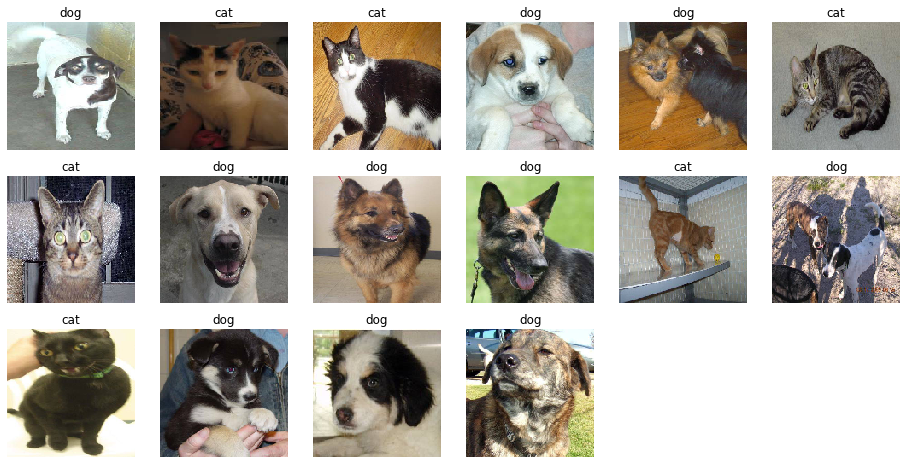

In [13]:
x, y = train_generator.next()

plt.figure(figsize=(16, 8))
for i, (img, label) in enumerate(zip(x, y)):
    plt.subplot(3, 6, i+1)
    if label == 1:
        plt.title('dog')
    else:
        plt.title('cat')
    plt.axis('off')
    plt.imshow(img, interpolation="nearest")

## Build the structure of ResNet-50 for Cats.Vs.Dogs

1. Define identity block.
2. Define convolution block.
3. Build the structure of ResNet-50 without top layer.
4. Load weights
5. Add top layer to ResNet-50.
6. Setup training attribute.
7. Compile the model.

### 1. Define identity block.

#### The identity_block is the block that has no conv layer at shortcut.

#### Arguments

- input_tensor: input tensor
- kernel_size: defualt 3, the kernel size of middle conv layer at main path
- filters: list of integers, the nb_filters of 3 conv layer at main path
- stage: integer, current stage label, used for generating layer names
-  block: 'a','b'..., current block label, used for generating layer names

In [36]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    
    nb_filter1, nb_filter2, nb_filter3 = filters
    if K.image_data_format() == 'tf':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Convolution2D(nb_filter1, 1, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter2, kernel_size, 
                      padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter3, 1, name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x

### 2. Define convolution block.

#### conv_block is the block that has a conv layer at shortcut

#### Arguments

- input_tensor: input tensor
- kernel_size: defualt 3, the kernel size of middle conv layer at main path
- filters: list of integers, the nb_filters of 3 conv layer at main path
- stage: integer, current stage label, used for generating layer names
- block: 'a','b'..., current block label, used for generating layer names

    *Note that from stage 3, the first conv layer at main path is with subsample=(2,2)
    And the shortcut should have subsample=(2,2) as well*

In [34]:
def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):

    nb_filter1, nb_filter2, nb_filter3 = filters
    if K.image_data_format() == 'tf':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Convolution2D(nb_filter1, 1, strides=strides,
                      name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter2, kernel_size, padding='same',
                      name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter3, 1, name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Convolution2D(nb_filter3, 1, strides=strides,
                             name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

### 3.Build the structure of ResNet-50 without top layer.

In [37]:
img_input = Input(shape=(image_width, image_height, 3))

x = ZeroPadding2D((3, 3))(img_input)
x = Convolution2D(64, 7, strides=(2, 2), name='conv1')(x)
x = BatchNormalization(axis=3, name='bn_conv1')(x)
x = Activation('relu')(x)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

base_model = Model(img_input, x)

### 4. Import ResNet50 model

In [42]:
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(150,150,3))
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_13[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

We lock all the layers of the convolutional part:

In [44]:
for layer in base_model.layers:
    layer.trainable = False

### 5. Add top layer to ResNet-50.

In [57]:
x = AveragePooling2D(name='avg_pool')(base_model.output)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid', name='output')(x)

model = Model(base_model.input, x)

In [ ]:
model.summary()

### 6. Compile the model.

In [58]:
model.compile(loss='binary_crossentropy', optimizer=SGD(lr=0.0001, momentum=0.9), metrics=['accuracy'])

## Train ResNet-50 for Cats.Vs.Dogs and Save the best model.

In [59]:
history=model.fit(
        train_generator,
        steps_per_epoch=10,
        epochs=40,
        validation_data=validation_generator,
        validation_steps=50)

Epoch 1/40
10/10 [==============================] - 5s 531ms/step - loss: 1.6126 - accuracy: 0.5938 - val_loss: 0.2551 - val_accuracy: 0.8963
Epoch 2/40
10/10 [==============================] - 4s 394ms/step - loss: 0.5241 - accuracy: 0.8375 - val_loss: 0.1893 - val_accuracy: 0.9325
Epoch 3/40
10/10 [==============================] - 5s 450ms/step - loss: 0.2159 - accuracy: 0.9312 - val_loss: 0.1554 - val_accuracy: 0.9450
Epoch 4/40
10/10 [==============================] - 4s 407ms/step - loss: 0.5186 - accuracy: 0.9187 - val_loss: 0.1569 - val_accuracy: 0.9475
Epoch 5/40
10/10 [==============================] - 4s 445ms/step - loss: 0.3198 - accuracy: 0.8875 - val_loss: 0.1527 - val_accuracy: 0.9563
Epoch 6/40
10/10 [==============================] - 5s 512ms/step - loss: 0.2202 - accuracy: 0.9250 - val_loss: 0.1729 - val_accuracy: 0.9513
Epoch 7/40
10/10 [==============================] - 4s 414ms/step - loss: 0.2240 - accuracy: 0.9312 - val_loss: 0.1320 - val_accuracy: 0.9588
Epoch 

In [61]:
model.save('cats_and_dogs_ResNet50.h5')

In [62]:
from google.colab import files
files.download("cats_and_dogs_ResNet50.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

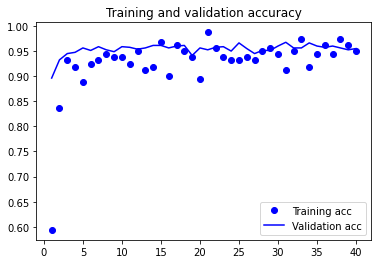

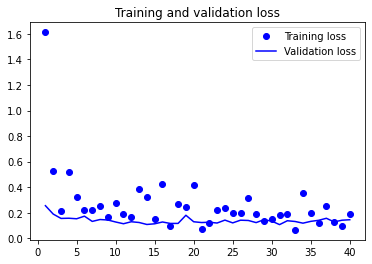

In [64]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Using the best model to predict images

In [66]:
from tensorflow.keras.models import load_model
model = load_model('cats_and_dogs_ResNet50.h5')

#### preprocessing the images in test dataset. The test folder in my google dirve is not the one used for testing.

In [75]:
def get_image(index):
    img = cv2.imread('test/%d.jpg' % index)
    img = cv2.resize(img, image_size)
    img.astype(np.float32)
    img = img / 255.0
    return img

test_num = 1000

In [76]:
from tqdm import *

image_matrix = np.zeros((test_num, image_width, image_height, 3), dtype=np.float32)

for i in tqdm(range(test_num)):
    image_matrix[i] = get_image(i+1)

  0%|          | 0/1000 [00:00<?, ?it/s]


error: ignored

In [ ]:
predictions = model.predict(image_matrix, verbose=1)

12500/12500 [==============================] - 68s    


### Save the result.csv for kaggle submit

In [ ]:
s = 'id,label\n'
for i, p in enumerate(predictions):
    s += '%d,%f\n' % (i+1, p)

with open('result.csv', 'w') as f:
    f.write(s)

## Visualization

### Show 20 random images and the prediction in the test folder by the classifier

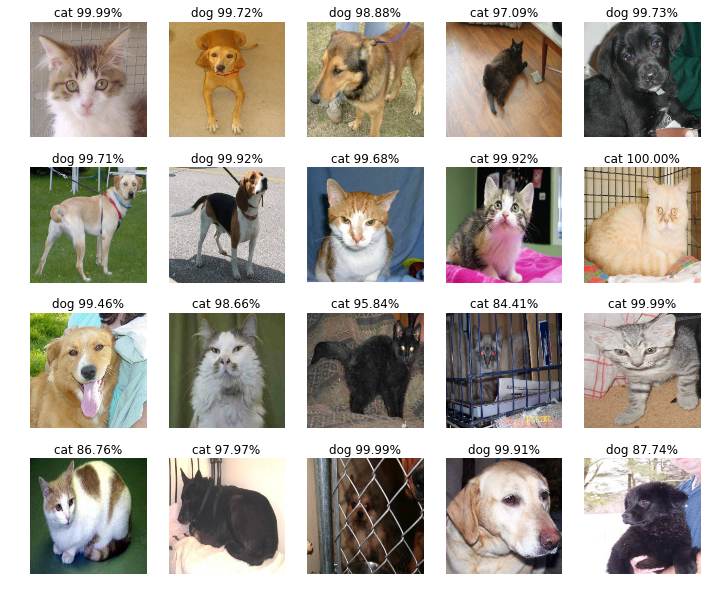

In [ ]:
plt.figure(figsize=(12, 10))
for i in range(20):
    x = get_image(random.randint(1, test_num))
    prediction = model.predict(np.expand_dims(x, axis=0))[0]
    
    plt.subplot(4, 5, i+1)
    if prediction < 0.5:
        plt.title('cat %.2f%%' % (100 - prediction*100))
    else:
        plt.title('dog %.2f%%' % (prediction*100))
    
    plt.axis('off')
    plt.imshow(x[:,:,::-1]) # convert BGR to RGB


## Draw feature heatmap

The shape of the output of the base model is (7, 7, 2048). 

The shape of the weights of full connection is (2048, 1). 

In order to draw the heatmap, I calculated the Class Activation Mapping (cam) of the output of the network then used OpenCV to visualize the result.

$cam = (P-0.5)*output*w$
- cam: class activation mapping
- P: the probability of cats or dogs
- output: the output of base model
- w: the weights of the full connection

In [ ]:
weights = model.layers[-1].get_weights()[0]
model2 = Model(input=model.input, output=[base_model.output, model.output])

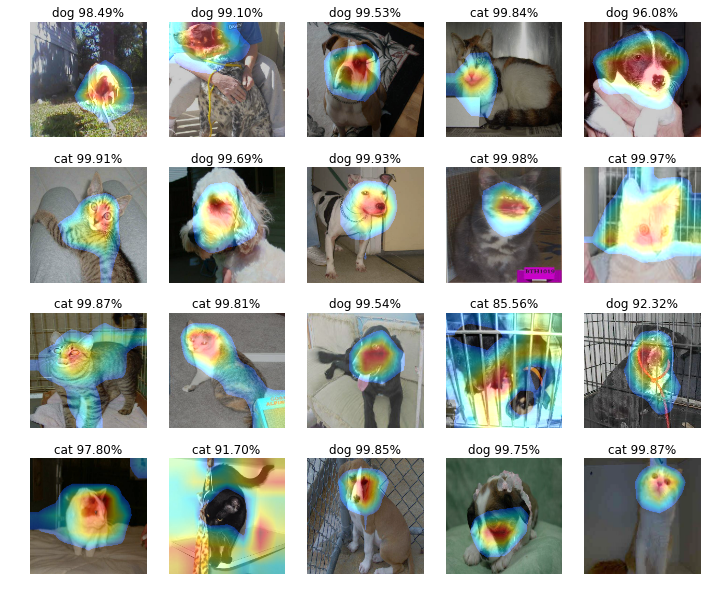

In [ ]:
plt.figure(figsize=(12, 10))
for i in range(20):
    img = cv2.imread('test/%d.jpg' % random.randint(1, test_num))
    img = cv2.resize(img, image_size)
    x = img.copy()
    x.astype(np.float32)
    x = x / 255.0
    
    [base_model_outputs, prediction] = model2.predict(np.expand_dims(x, axis=0))
    prediction = prediction[0]
    base_model_outputs = base_model_outputs[0]
    
    plt.subplot(4, 5, i+1)
    if prediction < 0.5:
        plt.title('cat %.2f%%' % (100 - prediction*100))
    else:
        plt.title('dog %.2f%%' % (prediction*100))
    
    cam = (prediction - 0.5) * np.matmul(base_model_outputs, weights)

    cam -= cam.min()
    cam /= cam.max()
    cam -= 0.2
    cam /= 0.8
    
    cam = cv2.resize(cam, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap[np.where(cam <= 0.2)] = 0
    
    out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)
    
    plt.axis('off')
    plt.imshow(out[:,:,::-1])